<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/imdb_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Sentiment Prediction with Embeddings layer



## Import

In [89]:
import os
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM,\
                        TextVectorization, MaxPooling1D, Dropout

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset

In [90]:
# Dataset - 2880 movie reviews from IMDB (raw string)
# 1440 positives, 1440 negatives

imdb_dir = '/content/drive/MyDrive/imdb-dataset/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

print("Example from dataset : ", texts[0])
print("Sentiment : ", "Negative" if labels[0] == 0 else "Positive")

Example from dataset :  Perhaps I'm being too generous when I give this film two and a half stars out of five, but there was an occasional moment. However, as "An American Werewolf" movie this one is a missed chance! There are no real plot connections to the superior original to speak of, but the story is similar in some ways to "London".<br /><br />*Possible Spoiler Warning* American kids go to foreign country, one falls in love with a beautiful girl. Another one of the kids gets slaughtered by a werewolf in the same night that one gets bitten, and despite his undead friend's warnings, by the light of the full moon he sprouts fur, fangs, and claws!<br /><br />But there are some differences in the story, for one; the girl is one of the werewolves. Second; there are three American Kids. And third; there's some weird-@$$ werewolf cult intent on taking over the world! As crazy as it sounds, that last one, WASN'T a joke! *Spoiler Ends*<br /><br />The films suffers from many things, first t

In [91]:
## Preprocessing - Normalize text

ponctuations = list(string.punctuation)
stop_words = stopwords.words('english')

def regularize(text):

    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = "".join([char for char in list(text) if not (char in ponctuations)])
    text = "".join([word for word in list(text) if not (word in stop_words)])
    text = re.sub("[0-9]","", text)

    return text

# texts = [regularize(text) for text in texts]

<WordListCorpusReader in '/root/nltk_data/corpora/stopwords'>


In [92]:
# Preprocessing - sentences to sequences

maxlen = 200
max_words = 10000
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 30050 unique tokens.
Shape of data tensor: (2880, 200)
Shape of label tensor: (2880,)


In [93]:
# Splitting for test set

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

x_set = data[indices]
y_set = labels[indices]

test_sep = int(len(x_set) * 0.2)

x_train = x_set[test_sep:]
y_train = y_set[test_sep:]

x_test = x_set[:test_sep]
y_test = y_set[:test_sep]

print("Found {} elements for train set".format(len(x_train)))
print("Found {} elements for test set".format(len(x_test)))

Found 2304 elements for train set
Found 576 elements for test set


## Model

In [94]:
# Model defintion - This model should predict the sentiment of a review

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(MaxPooling1D(pool_size=5, strides=2))
model.add(Dropout(0.7))
model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 100)          1000000   
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 98, 100)          0         
 g1D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 98, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                17024     
                                                                 
 flatten_8 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                     

## Training

In [95]:
# Training

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/15
58/58 [==============================] - 8s 93ms/step - loss: 0.7777 - acc: 0.5198 - val_loss: 0.7579 - val_acc: 0.4642
Epoch 2/15
58/58 [==============================] - 6s 99ms/step - loss: 0.7160 - acc: 0.6278 - val_loss: 0.7480 - val_acc: 0.5380
Epoch 3/15
58/58 [==============================] - 6s 101ms/step - loss: 0.5831 - acc: 0.7347 - val_loss: 0.6775 - val_acc: 0.5662
Epoch 4/15
58/58 [==============================] - 5s 86ms/step - loss: 0.4334 - acc: 0.8378 - val_loss: 0.4630 - val_acc: 0.8156
Epoch 5/15
58/58 [==============================] - 7s 118ms/step - loss: 0.2987 - acc: 0.9040 - val_loss: 0.6361 - val_acc: 0.7787
Epoch 6/15
58/58 [==============================] - 5s 83ms/step - loss: 0.2126 - acc: 0.9376 - val_loss: 0.4184 - val_acc: 0.8395
Epoch 7/15
58/58 [==============================] - 5s 87ms/step - loss: 0.1605 - acc: 0.9588 - val_loss: 0.3856 - val_acc: 0.8633
Epoch 8/15
58/58 [==============================] - 7s 114ms/step - loss: 0.1232 

## Results

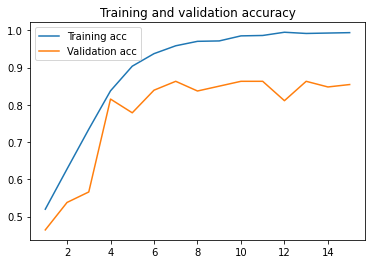

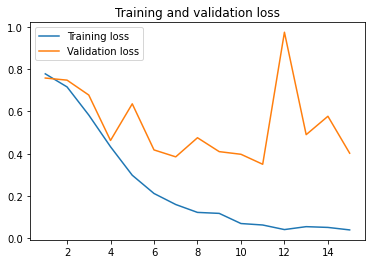

In [96]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [98]:
# Evaluate

loss, acc  = model.evaluate(x_test, y_test)
print("Accuracy : {}%".format(acc*100))

18/18 [==============================] - 0s 16ms/step - loss: 0.4434 - acc: 0.8663
Accuracy : 86.63194179534912%
